# Test

Il notebook sarà diviso in due parti:
<ol>
<li>Importazione del video;</li>
<li>test dei metodi del paper.</li>
</ol>


## Importazione del video

Alla fine mi sono scaricato il video da Youtube

In [1]:
# Simply view the video
from IPython.display import Video

Video("videoplayback.mp4")

## Test

In [2]:
import numpy as np
import cv2 as cv

In [3]:
# get important imformation
capture = cv.VideoCapture('videoplayback.mp4')
cv.namedWindow('Video', cv.WINDOW_NORMAL)

if capture.isOpened(): 
    #cerco le dimensioni di un frame e altri dati utili
    width  = capture.get(cv.CAP_PROP_FRAME_WIDTH)   # tutti float
    height = capture.get(cv.CAP_PROP_FRAME_HEIGHT)  

    print('width: ', width)
    print('height:', height)
    
    fps = capture.get(cv.CAP_PROP_FPS)
    
    print('fps:', fps)  # float `fps`
    
    frame_count = capture.get(cv.CAP_PROP_FRAME_COUNT)
    
    print('frames count:', frame_count)  # float `frame_count`
    
while capture.isOpened(): 
    
    ret, frame = capture.read()
    
        #checking if the video has ended
    if not ret:
        print("No frame (stream end?). Exiting ...")
        cv.destroyAllWindows()
        break
    
        #put in a box the time of the video
    cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv.putText(frame, str(round(capture.get(cv.CAP_PROP_POS_FRAMES)/capture.get(cv.CAP_PROP_FPS),2)), (15, 15),
               cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    
    cv.imshow('Video', frame)
    
    keyboard = cv.waitKey(round(fps))
    if keyboard == 'q' or keyboard == 27:
        break
capture.release()

width:  600.0
height: 360.0
fps: 29.969215408935852
frames count: 1801.0
No frame (stream end?). Exiting ...


## TUTTO

In [4]:
#COSTANTI (Fissati già al training dell'SVM)
IMG_HEIGHT, IMG_WIDTH = (20, 20)

#PARAMETRI DA SETTARE
# choose the subtractor
#subtractor = cv.bgsegm.createBackgroundSubtractorGMG(initializationFrames=10, decisionThreshold=0.9)
subtractor = cv.createBackgroundSubtractorMOG2()

threshold = 200

#PARAMETRI DEL BLOB DETECTOR
params = cv.SimpleBlobDetector_Params()

params.blobColor = 255

# Filter by Area.
params.filterByArea = True
params.minArea = 400
params.maxArea = 10000

detector = cv.SimpleBlobDetector_create(params)

#perform a dilation and a erosion to erase the 'noise'
erosion_size = 5
    #the argument can be: cv.MORPH_RECT, cv.MORPH_CROSS, cv.MORPH_ELLIPSE
erosion_shape = cv.MORPH_RECT

In [5]:
from joblib import dump, load
best_SVM = load('best_model.joblib')

In [6]:
import pandas as pd
columns = ['x1','y1','x2','y2','frame_number']
DOME_df = pd.DataFrame(columns = columns)

In [7]:
capture = cv.VideoCapture('videoplayback.mp4')

#create resizable windows
#cv.namedWindow('Original video', cv.WINDOW_NORMAL)
cv.namedWindow('Foreground PRE', cv.WINDOW_NORMAL)
cv.namedWindow('Foreground POST', cv.WINDOW_NORMAL)
cv.namedWindow('Keypoints', cv.WINDOW_NORMAL)
cv.namedWindow('Opened Image', cv.WINDOW_NORMAL)

counter = -1

while capture.isOpened():
    ret, frame = capture.read()
    
    
        #checking if the video has ended
    if not ret:
        print("No frame (stream end?). Exiting ...")
        cv.destroyAllWindows()
        break
    counter += 1
    if counter % 100 == 0: print(counter)
    
    fgmask = subtractor.apply(frame)
    
    cv.imshow('Foreground PRE', fgmask)
    
    #THRESHOLDING
    (T, gray) = cv.threshold(fgmask, threshold, 255, cv.THRESH_BINARY)
    
    #FLOOD FILLING
    im_floodfill = gray.copy()
    h, w = gray.shape
    mask = np.zeros((h+2, w+2), np.uint8)
    # Floodfill from point (0, 0)
    cv.floodFill(im_floodfill, mask, (0,0), 255);
    # Invert floodfilled image
    im_floodfill_inv = cv.bitwise_not(im_floodfill)
    # Combine the two images to get the foreground.
    im_out = cv.bitwise_or(gray, im_floodfill_inv)
    # Display images
    cv.imshow('Foreground POST', im_out)

    
    #BLOB DETECTOR
    kernel = cv.getStructuringElement(erosion_shape, (2 * erosion_size + 1, 2 * erosion_size + 1),
                                       (erosion_size, erosion_size))
    
    erosion_dst = cv.erode(im_out, kernel)
        
    dilatation_dst = cv.dilate(erosion_dst, kernel)
    
    cv.imshow("Opened Image", dilatation_dst)
    
    keypoints = detector.detect(dilatation_dst)
    

    
    for keypoint in keypoints:
        x, y = keypoint.pt
        side = keypoint.size/2
        x1 = round(x-side)
        y1 = round(y-side)
        x2 = round(x+side)
        y2 = round(y+side)
        mydict = {
            'x1' : x1,
            'y1' : y1,
            'x2' : x2,
            'y2' : y2,
            'frame_number' : counter
        }
        #mydf = pd.DataFrame(mydict, index = [0])
        #DOME_df = DOME_df.append(mydf, ignore_index = True)
            
        if y1 > 0 and x1 > 0:
            vehicle = frame[y1:y2,x1:x2]
            if  side*side > IMG_HEIGHT*IMG_WIDTH:
                vehicle=cv.resize(vehicle, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv.INTER_AREA)
                vehicle =np.array(vehicle, np.float32)
                vehicle /= 255 
                vehicle = vehicle.reshape(1,-1)
                prediction = best_SVM.predict(vehicle)
                
                frame = cv.rectangle(frame, (x1, y1), (x2, y2), (0,0,255), 2, cv.FILLED)
                
                if prediction == 0:
                    text = 'Bus'
                elif prediction == 1:
                    text = 'Car'
                else:
                    text = 'Truck'
                mydict['classId'] = text
                mydf = pd.DataFrame(mydict, index = [0])
                DOME_df = DOME_df.append(mydf, ignore_index = True)
            
                    # Finds space required by the text so that we can put a background with that amount of width.
                (w, h), _ = cv.getTextSize(text, cv.FONT_HERSHEY_SIMPLEX, 0.6, 1)
                
                # Prints the text.    
                frame = cv.rectangle(frame, (x1, y1- 20), (x1 + w, y1), (0,0,255), -1)
                frame = cv.putText(frame, text, (x1, y1-5),cv.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 1)



    #im_with_keypoints = cv.drawKeypoints(frame, keypoints, np.array([]), (0,0,255), 
    #                                     cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    cv.imshow('Keypoints', frame)
    keyboard = cv.waitKey(round(fps))
    if keyboard == 'q' or keyboard == 27:
        break
capture.release()
#out.release()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
No frame (stream end?). Exiting ...


In [8]:
DOME_df = DOME_df[DOME_df.frame_number % 10 == 0]

DOME_df

,x1,y1,x2,y2,frame_number,classId
2,550,178,601,230,70,Car
12,491,143,532,185,80,Truck
15,553,192,602,240,200,Truck
27,556,193,602,239,580,Truck
51,438,177,481,220,690,Car
57,536,178,593,235,720,Car
64,483,150,523,191,730,Truck
70,506,230,596,319,750,Car
72,548,297,607,356,810,Bus
80,536,188,586,238,930,Truck


## Roba di Ale
GT data:

In [9]:
import json

nframes = 181
class_dict = {1:'car', 2:'truck', 3:'no_class', 4:'bus'}
columns = ['x1','y1','x2','y2','classId','frame_number']
GT_df = pd.DataFrame(columns = columns)

for i in np.arange(nframes)*10:
    filename = './GroundTruth/frame_%d.jpg.json' % i 
    data = json.load(open(filename))
    if len(data["tags"]) == 0:
        L = len(data["instances"])
        dicts = []
        for j in range(L):
            mydict = {
                'x1' : data["instances"][j]["points"]["x1"],
                'y1' : data["instances"][j]["points"]["y1"],
                'x2' : data["instances"][j]["points"]["x2"],
                'y2' : data["instances"][j]["points"]["y2"],
                'classId' : class_dict[data["instances"][j]["classId"]],
                'frame_number' : i
            }
            dicts.append(mydict)
        new_df = pd.DataFrame.from_dict(dicts)
        GT_df = GT_df.append(new_df, ignore_index = True)
GT_df['frame_number'] = GT_df['frame_number'].astype(int)
GT_df['classId'] = GT_df['classId'].astype('str') 
GT_df

,x1,y1,x2,y2,classId,frame_number
0,249.141968,86.870743,266.399994,97.800003,car,30
1,236.600000,94.700000,253.000000,109.600000,car,50
2,228.000000,95.500000,247.600000,111.900000,car,60
3,213.924103,97.827415,236.600006,118.199997,car,70
4,541.058960,178.437210,600.000000,230.100006,car,70
...,...,...,...,...,...,...
348,387.665588,114.262421,404.100006,126.800003,truck,1750
349,382.200000,110.400000,395.500000,122.900000,truck,1760
350,481.579926,216.002930,559.799988,279.399994,car,1790
351,431.500000,176.900000,481.700000,216.600000,car,1800


Funzioni:

In [59]:
def compute_overlap(A, B, classif = False):    #total GT df and grouped PRED df
    a_idx = A.index
    b_idx = B.index
    area_pcg = 0.5
    XA1 = float(A['x1'])
    XA2 = float(A['x2'])
    YA1 = float(A['y1'])
    YA2 = float(A['y2'])
    XB1 = float(B['x1'])
    XB2 = float(B['x2'])
    YB1 = float(B['y1'])
    YB2 = float(B['y2'])
    A_area = abs(XA1-XA2)*abs(YA1-YA2)
    B_area = abs(XB1-XB2)*abs(YB1-YB2)
    overlap_area = max(0, min(XA2, XB2) - max(XA1, XB1)) * max(0, min(YA2, YB2) - max(YA1, YB1))
    IoU = overlap_area/(A_area + B_area - overlap_area)
    if IoU >= area_pcg:
        if classif:  
            if isinstance(B.loc[b_idx,'classId'].values[0], str):
                a_class = A.loc[a_idx,'classId'].values[0].strip().lower()
                b_class = B.loc[b_idx,'classId'].values[0].strip().lower()
                y_pred.append(b_class)
                y_true.append(a_class)
                if a_class==b_class:
                    B.loc[b_idx,'Recognized'] = True
            else:
                B.loc[b_idx,'Recognized'] = np.nan
        else:
            B.loc[b_idx,'Recognized'] = True

def scoring_grouped_df(whole_gt_df, grouped_pred_df, classif = False):
    frame = grouped_pred_df['frame_number'].values[0]
    gt_df = whole_gt_df[whole_gt_df['frame_number']==frame]
    for i in gt_df.index:
        test_A = gt_df[gt_df.index == i]
        compute_overlap(test_A, grouped_pred_df, classif)
    return grouped_pred_df

def recall_normalization(p_df, gt_df):
    frame_num = int(p_df['frame_number'].values[0])
    g_df = gt_df[gt_df['frame_number']==frame_num]
    L = g_df.shape[0]
    if L != 0:
        return min(1,sum(p_df.Recognized)/L)
    else:
        return np.nan

score GMG:

In [60]:
#Takes 40s to compute
PRED_df = DOME_df

PRED_df['Recognized'] = False
y_pred, y_true = [], []
PRED_df = PRED_df.groupby(PRED_df.index).apply(lambda row : scoring_grouped_df(GT_df, row, classif=False))

PRED_df
Recall = PRED_df.groupby('frame_number').apply(lambda x : recall_normalization(x, GT_df)).to_frame(name='Recall')
Precision = PRED_df.groupby('frame_number').apply(lambda x : sum(x.Recognized)/x.shape[0]).to_frame(name='Precision')
Results = pd.concat([Recall, Precision], axis=1)
Results

,Recall,Precision
frame_number,,
110,0.500000,1.0
120,0.500000,1.0
200,0.333333,1.0
210,0.333333,1.0
230,0.666667,1.0
400,0.500000,1.0
410,0.500000,1.0
420,1.000000,1.0
430,0.333333,1.0


In [61]:
p_det = np.nanmean(Results.Precision)
p_det

0.9722222222222222

In [62]:
r_det = np.nanmean(Results.Recall)
r_det

0.5393518518518517

In [63]:
def boh(x):
    if all([isinstance(y,bool) for y in x]):
        return sum(x)/len(x)
    else: 
        return np.nan  

In [64]:
#Takes 40s to compute
PRED_df = DOME_df

PRED_df['Recognized'] = False
y_pred, y_true = [], []
PRED_df = PRED_df.groupby(PRED_df.index).apply(lambda row : scoring_grouped_df(GT_df, row, classif=True))

Recall = PRED_df.groupby('frame_number').apply(lambda x : recall_normalization(x, GT_df)).to_frame(name='Recall')
Precision = PRED_df.groupby('frame_number').apply(lambda x : boh(x.Recognized.tolist())).to_frame(name='Precision')
Results = pd.concat([Recall, Precision], axis=1)
Results

,Recall,Precision
frame_number,,
110,0.000000,0.0
120,0.000000,0.0
200,0.333333,1.0
210,0.000000,0.0
230,0.000000,0.0
400,0.000000,0.0
410,0.500000,1.0
420,0.000000,0.0
430,0.333333,1.0


In [65]:
p_class = np.nanmean(Results.Precision)
p_class

0.375

In [66]:
r_class = np.nanmean(Results.Recall)
r_class

0.18287037037037035

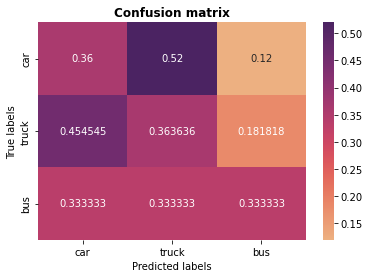

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cmap = sns.color_palette("flare", as_cmap=True)

ax = plt.axes()
labels=["car", "truck", "bus"]
cm = confusion_matrix(y_true, y_pred, labels=labels, normalize = 'true')
sns.heatmap(cm, annot=True, cmap=cmap, fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
ax.set_title('Confusion matrix', fontweight="bold")
plt.savefig('./Results/CMatrix_GMG.png')

plt.show()

# FINE

In [68]:
print(p_det, r_det, p_class, r_class)
#GMG_scores = {
#    'p_det' : p_det,
#    'r_det' : r_det,
#    'p_class' : p_class,
#    'r_class' : r_class
#}
GMG_scores = {
    'p_det' : p_det,
    'r_det' : r_det,
    'p_class' : p_class,
    'r_class' : r_class
}

0.9722222222222222 0.5393518518518517 0.375 0.18287037037037035


GMG: 0.9722222222222222 0.5393518518518517 0.375 0.18287037037037035

In [69]:
GMG_scores

{'p_det': 0.9722222222222222,
 'r_det': 0.5393518518518517,
 'p_class': 0.375,
 'r_class': 0.18287037037037035}

In [70]:
MOG2_scores

{'p_det': 0.9545454545454546,
 'r_det': 0.509090909090909,
 'p_class': 0.38636363636363635,
 'r_class': 0.23106060606060605}

In [71]:
GMG_scores_df = pd.DataFrame(GMG_scores, index = ['GMG'])
MOG2_score_df = pd.DataFrame(MOG2_scores, index = ['MoG2'])
scores_df = pd.concat([GMG_scores_df, MOG2_score_df], axis=0)
scores_df

,p_det,r_det,p_class,r_class
GMG,0.972222,0.539352,0.375000,0.182870
MoG2,0.954545,0.509091,0.386364,0.231061


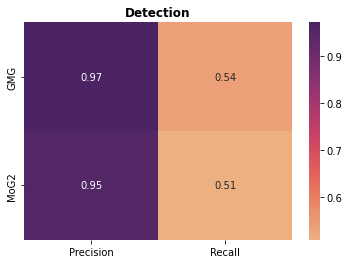

In [72]:

cmap = sns.color_palette("flare", as_cmap=True)

ax = plt.axes()
sns.heatmap(scores_df[['p_det', 'r_det']], annot=True, cmap=cmap, ax=ax)
ax.set_title('Detection', fontweight="bold")
ax.set_xticklabels(['Precision', 'Recall'])

plt.savefig('./Results/GMG_MOG2_detection.png')
plt.show()

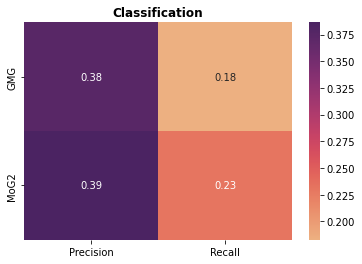

In [73]:
ax = plt.axes()
sns.heatmap(scores_df[['p_class', 'r_class']], annot=True, cmap=cmap, ax=ax)
ax.set_title('Classification', fontweight="bold")
ax.set_xticklabels(['Precision', 'Recall'])

plt.savefig('./Results/GMG_MOG2_classification.png')
plt.show()

# Video

In [10]:
import cv2

In [15]:
def object_detection_api(img_path, video_writer, gt, pred, count, rect_th=3, text_size=3, text_th=3, plot = False, save = False, video = True):
    GT = gt[gt.frame_number == count]
    gt_boxes = GT[['x1','y1','x2','y2']]
    gt_cls = GT['classId']
    PRED = pred[pred.frame_number == count]
    pred_boxes = PRED[['x1','y1','x2','y2']]
    pred_cls = PRED['classId']
    # Get predictions
    img = cv2.imread(img_path)
    # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Convert to RGB
    for i in pred_boxes.index:
        x1 = round(pred_boxes.loc[i,'x1'])
        y1 = round(pred_boxes.loc[i,'y1'])
        x2 = round(pred_boxes.loc[i,'x2'])
        y2 = round(pred_boxes.loc[i,'y2'])
        cv2.rectangle(img, (x1,y1), (x2,y2), color=(0,255,0), thickness=rect_th)
        # Draw Rectangle with the coordinates
        cv2.putText(img, pred_cls[i], (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0), thickness=text_th)
        # Write the prediction class
    for i in gt_boxes.index:
        x1 = round(gt_boxes.loc[i,'x1'])
        y1 = round(gt_boxes.loc[i,'y1'])
        x2 = round(gt_boxes.loc[i,'x2'])
        y2 = round(gt_boxes.loc[i,'y2'])
        cv2.rectangle(img, (x1,y1), (x2,y2), color=(0,0,255), thickness=rect_th)
        # Draw Rectangle with the coordinates
        cv2.putText(img, gt_cls[i], (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,0,255), thickness=text_th)
        # Write the prediction class
    u_p, c_p = np.unique(pred_cls,return_counts=True)
    u_p = [u.lower() for u in u_p]
    pd_dict = dict(zip(u_p,c_p))
    if 'car' not in u_p: pd_dict['car'] = 0
    if 'truck' not in u_p: pd_dict['truck'] = 0
    if 'bus' not in u_p: pd_dict['bus'] = 0
    u_g, c_g = np.unique(gt_cls,return_counts=True)
    gt_dict = dict(zip(u_g,c_g))
    if 'car' not in u_g: gt_dict['car'] = 0
    if 'truck' not in u_g: gt_dict['truck'] = 0
    if 'bus' not in u_g: gt_dict['bus'] = 0
    cv2.rectangle(img, (0,0), (140,104), color=(255, 255, 255), thickness = -1)
    cv2.putText(img, 'Cars = '+str(pd_dict['car'])+'/'+str(gt_dict['car']), (12,24), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0),thickness=1)
    cv2.putText(img, 'Trucks = '+str(pd_dict['truck'])+'/'+str(gt_dict['truck']), (12,56), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0),thickness=1)
    cv2.putText(img, 'Buses = '+str(pd_dict['bus'])+'/'+str(gt_dict['bus']), (12,88), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0),thickness=1)
    if plot:
        plt.figure(figsize=(10,20))
        # display the output image
        plt.imshow(img) 
        plt.xticks([]) 
        plt.yticks([]) 
        if save:
            plt.savefig('./Results/frame%d.png' % count)
        plt.show()
    if video:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        video_writer.write(img)

In [16]:
capture = cv2.VideoCapture('videoplayback.mp4')
width  = round(capture.get(cv2.CAP_PROP_FRAME_WIDTH))   
height = round(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = round(capture.get(cv2.CAP_PROP_FPS))
capture.release()

fourcc = cv2.VideoWriter_fourcc(*'mp4v')

video_writer = cv2.VideoWriter('./Results/output_video_MOG2.mp4',fourcc,fps,(width,height))

for k in np.arange(181)*10:    
    frame_path = "frames/frame%d.jpg" % k
    object_detection_api(frame_path, video_writer, GT_df, DOME_df, k, rect_th=1, text_th=1, text_size=0.3)

video_writer.release()

## Metodi GMG e MOG2

In [8]:
capture = cv.VideoCapture('videoplayback.mp4')

#create resizable windows
cv.namedWindow('Original video', cv.WINDOW_NORMAL)
cv.namedWindow('Foreground Mask with GMG', cv.WINDOW_NORMAL)
cv.namedWindow('Foreground Mask with MOG2', cv.WINDOW_NORMAL)

while capture.isOpened():
    ret, frame = capture.read()
    
        #checking if the video has ended
    if not ret:
        print("No frame (stream end?). Exiting ...")
        cv.destroyAllWindows()
        break
    
    fgmaskGMG = GMGsubtractor.apply(frame)
    fgmaskMOG2 = MOG2subtractor.apply(frame)
    
        #put in a box the time of the video
    cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv.putText(frame, str(round(capture.get(cv.CAP_PROP_POS_FRAMES)/capture.get(cv.CAP_PROP_FPS),2)), (15, 15),
               cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    
    cv.imshow('Original video', frame)
    cv.imshow('Foreground Mask with GMG', fgmaskGMG)
    print(fgmaskGMG.shape)
    cv.imshow('Foreground Mask with MOG2', fgmaskMOG2)
    
    keyboard = cv.waitKey(round(fps))
    if keyboard == 'q' or keyboard == 27:
        break
capture.release()

NameError: name 'GMGsubtractor' is not defined

## Processing the mask:
In questa sezione seguo il framework del paper:
<ol>
<li>Thresholding</li>
<li>(Inverse) Flood Filling for filling holes</li>
</ol>
Finita questa fase di preprocessing, la maschera ottenuta può essere utilizzata da un Blob Detector.

### 1. Thresholding

In [ ]:
# Saving the result in a new video
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter('processed_mask.avi',fourcc, round(fps), (600,360), isColor = False)

In [ ]:
capture = cv.VideoCapture('GMG_mask.avi')

threshold = 200
cv.namedWindow('Threshold Binary', cv.WINDOW_NORMAL)
cv.namedWindow('Original mask', cv.WINDOW_NORMAL)

while capture.isOpened():
    ret, frame = capture.read()
    
    if not ret:
        print("No frame. Stream end?. Exiting...")
        cv.destroyAllWindows()
        break
    
    (T, thld_mask) = cv.threshold(frame, threshold, 255, cv.THRESH_BINARY)
    
    gray = cv.cvtColor(thld_mask, cv.COLOR_BGR2GRAY)
    cv.imshow("Threshold Binary", gray)
    cv.imshow('Original mask', frame)
    
    #NEED TO TRANSFORM TO GRAYSCALE
    out.write(gray)
    
    keyboard = cv.waitKey(round(fps))
    if keyboard == 'q' or keyboard == 27:
        break
cap.release()
out.release()

### 2. (Inverse) Flood Filling for filling the holes

In [ ]:
cap = cv.VideoCapture('processed_mask.avi')

width  = cap.get(cv.CAP_PROP_FRAME_WIDTH) 
height = cap.get(cv.CAP_PROP_FRAME_HEIGHT)  
print('width: ', width)
print('height:', height)

fps = cap.get(cv.CAP_PROP_FPS)
print('fps:', fps)  # float `fps`

frame_count = cap.get(cv.CAP_PROP_FRAME_COUNT)
print('frames count:', frame_count)

In [ ]:
# Saving the result in a new video
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter('foreground.avi',fourcc, round(fps), (600,360), isColor = False)

In [ ]:
cap_thld = cv.VideoCapture('processed_mask.avi')

cv.namedWindow("Thresholded Image", cv.WINDOW_NORMAL)
cv.namedWindow("Floodfilled Image", cv.WINDOW_NORMAL)
cv.namedWindow("Inverted Floodfilled Image", cv.WINDOW_NORMAL)
cv.namedWindow("Foreground", cv.WINDOW_NORMAL)

while cap_thld.isOpened():
    ret_thld, frame_thld = cap_thld.read()
    
    if not ret_thld:
        print("No frame. Stream end?. Exiting...")
        cv.destroyAllWindows()
        break
    
    frame_thld = cv.cvtColor(frame_thld, cv.COLOR_BGR2GRAY)
    im_floodfill = frame_thld.copy()
    
    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = frame_thld.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    # Floodfill from point (0, 0)
    cv.floodFill(im_floodfill, mask, (0,0), 255);
    # Invert floodfilled image
    im_floodfill_inv = cv.bitwise_not(im_floodfill)
    
    
    # Combine the two images to get the foreground.
    im_out = cv.bitwise_or(frame_thld, im_floodfill_inv)
    
    # Display images
    cv.imshow("Thresholded Image", frame_thld)
    cv.imshow("Floodfilled Image", im_floodfill)
    cv.imshow("Inverted Floodfilled Image", im_floodfill_inv)
    cv.imshow("Foreground", im_out)
    
    out.write(im_out)
    
    keyboard = cv.waitKey(round(fps))
    if keyboard == 'q' or keyboard == 27:
        break
cap_thld.release()
out.release()

## Blob detector

In [ ]:
params = cv.SimpleBlobDetector_Params()

# Change thresholds
#params.minThreshold = 5;
#params.maxThreshold = 500;

params.blobColor = 255

# Filter by Area.
params.filterByArea = True
params.minArea = 500
params.maxArea = 10000

# Filter by Circularity
params.filterByCircularity = False
params.minCircularity = 0.2

# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.1

# Filter by Inertia
params.filterByInertia = False
params.minInertiaRatio = 0.1


IMG_HEIGHT, IMG_WIDTH = (20, 20)

In [ ]:
# Saving the result in a new video
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter('bboxes.avi',fourcc, round(fps), (600,360), isColor = True)

In [ ]:
#checking the result
capture = cv.VideoCapture('foreground.avi')
cap = cv.VideoCapture('videoplayback.mp4')

width  = capture.get(cv.CAP_PROP_FRAME_WIDTH) 
height = capture.get(cv.CAP_PROP_FRAME_HEIGHT)  
print('width: ', width)
print('height:', height)

fps = capture.get(cv.CAP_PROP_FPS)
print('fps:', fps)  # float `fps`

frame_count = capture.get(cv.CAP_PROP_FRAME_COUNT)
print('frames count:', frame_count)

detector = cv.SimpleBlobDetector_create(params)

#create resizable windows
cv.namedWindow('Foreground', cv.WINDOW_NORMAL)
cv.namedWindow('Keypoints', cv.WINDOW_NORMAL)

count = 0
path = '/home/domenico/Desktop/train'

while capture.isOpened():
    ret, frame = capture.read()
    _, frame_original = cap.read()
    
        #checking if the video has ended
    if not ret:
        print("No frame (stream end?). Exiting ...")
        cv.destroyAllWindows()
        break
        
    #perform a dilation and a erosion to erase the 'noise'
    erosion_size = 5
        #the argument can be: cv.MORPH_RECT, cv.MORPH_CROSS, cv.MORPH_ELLIPSE
    erosion_shape = cv.MORPH_RECT
    kernel = cv.getStructuringElement(erosion_shape, (2 * erosion_size + 1, 2 * erosion_size + 1),
                                       (erosion_size, erosion_size))
    
    erosion_dst = cv.erode(frame, kernel)
        
    dilatation_dst = cv.dilate(erosion_dst, kernel)
    
    keypoints = detector.detect(dilatation_dst)
    

    #im_with_keypoints = cv.drawKeypoints(frame_original, keypoints, np.array([]), (0,0,255), 
    #                                     cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    for keypoint in keypoints:
        x, y = keypoint.pt
        side = keypoint.size/2
        x1 = round(x-side)
        y1 = round(y-side)
        x2 = round(x+side)
        y2 = round(y+side)
        if y1 > 0 and x1 > 0:
            vehicle = frame_original[y1:y2,x1:x2]
            if 
            vehicle=cv.resize(vehicle, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv.INTER_AREA)
            vehicle =np.array(vehicle, np.float32)
            vehicle /= 255 
            vehicle = vehicle.reshape(1,-1)
            prediction = best_SVM.predict(vehicle)

        frame_original = cv.rectangle(frame_original, (x1, y1), (x2, y2), (0,0,255), 2, cv.FILLED)
        
 
        # For the text background
        # Finds space required by the text so that we can put a background with that amount of width.
        if prediction == 0:
            text = 'Bus'
        elif prediction == 1:
            text = 'Car'
        else:
            text = 'Truck'
            
        (w, h), _ = cv.getTextSize(text, cv.FONT_HERSHEY_SIMPLEX, 0.6, 1)

        # Prints the text.    
        frame_original = cv.rectangle(frame_original, (x1, y1- 20), (x1 + w, y1), (0,0,255), -1)
        frame_original = cv.putText(frame_original, text, (x1, y1-5),cv.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 1)
    
    cv.imshow('Foreground', frame)
    cv.imshow('Keypoints', frame_original)
    
    out.write(frame_original)

    keyboard = cv.waitKey(round(fps))
    if keyboard == 'q' or keyboard == 27:
        break
capture.release()
cap.release()
out.release()

In [ ]:
target_dict

In [ ]:
capture = cv.VideoCapture('bboxes.avi')

width  = capture.get(cv.CAP_PROP_FRAME_WIDTH) 
height = capture.get(cv.CAP_PROP_FRAME_HEIGHT)  
print('width: ', width)
print('height:', height)

fps = capture.get(cv.CAP_PROP_FPS)
print('fps:', fps)  # float `fps`

frame_count = capture.get(cv.CAP_PROP_FRAME_COUNT)
print('frames count:', frame_count)

## SVM

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from PIL import Image
import keras
# For one-hot-encoding
from keras.utils import np_utils
# For creating sequenttial model
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
# For saving and loading models
from keras.models import load_model

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid={'C':[14,14.5,15],'gamma':[0.002,0.0021,0.0025],'kernel':['rbf']}
#param_grid={'C':[0.1,1,10],'gamma':[0.0001]}
svc=SVC()
model=GridSearchCV(svc,param_grid,cv=5, return_train_score=True)

In [ ]:
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
    n_removed = 0
   
    for dir1 in os.listdir(img_folder):
        print(dir1)
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv.imread( image_path, cv.COLOR_BGR2RGB)
            width, height,_ = image.shape
            if width <IMG_WIDTH:
                os.remove(image_path)
                n_removed = n_removed +1
            elif height < IMG_HEIGHT:
                os.remove(image_path)
                n_removed = n_removed +1
            else:
                image=cv.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv.INTER_AREA)
                image=np.array(image)
                image = image.astype('float32')
                image /= 255 
                img_data_array.append(image)
                class_name.append(dir1)
        print('Elements removed: ', n_removed)
    return img_data_array, class_name# extract the image array and class name

In [ ]:
IMG_HEIGHT, IMG_WIDTH = (20, 20)

img_data, class_name =create_dataset(r'/home/domenico/Desktop/train/val')

In [ ]:
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
target_dict

In [ ]:
target_val=  [target_dict[class_name[i]] for i in range(len(class_name))]

In [ ]:
x_train=np.array(img_data, np.float32)
y_train=np.array(list(map(int,target_val)), np.float32)

In [ ]:
n_imgs= x_train.shape[0]
X_train = x_train.reshape(n_imgs, -1)
#d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))

In [ ]:
model.fit(X_train,y_train)
# model.best_params_ contains the best parameters obtained from GridSearchCV

In [ ]:
print ('RESULTS FOR LINEAR KERNEL\n')

print("Best parameters set found:")
# ADD CODE
print(model.best_params_)

print("Score with best parameters:")
# ADD CODE
print(model.best_score_)

print("\nAll scores on the grid:")
# ADD CODE
print(model.cv_results_['mean_test_score'])

In [ ]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")

input_dictionary = model.best_params_
in2 = model.best_score_
 
#open file
file = open("params.txt", "a")
 
#convert variable to string
file.write("Kernel: rbf   "+current_time+"\n")
str = repr(param_grid)
file.write("param_grid = " + str + "\n")
str = repr(input_dictionary)
file.write("input_dictionary = " + str + "\n")
str = repr(in2)
file.write("Best score = " + str + "\n\n")
 
#close file
file.close()

In [ ]:
from joblib import dump, load
dump(best_SVM, 'best_model.joblib')

In [ ]:
best_parameters= {'C': [14.5], 'gamma': [0.002]}
best_SVM = GridSearchCV(SVC(kernel='rbf'), best_parameters, cv=5, return_train_score=True) # ADD CODE

# fit the model on the entire training set
# ADD CODE
best_SVM.fit(X_train, y_train)

#get the training and test error
training_error = 1. - best_SVM.score(X_train,y_train)
#test_error = 1. - best_SVM.score(X_test,y_test)

print ("Best SVM training error: %f" % training_error)
#print ("Best SVM test error: %f" % test_error)

In [ ]:
from joblib import dump, load
best_SVM = load('best_model.joblib')